In [6]:
# 2-zone propagation from 1012.4515v4 
from scipy.special import * 
from scipy import integrate
import numpy as np
import multiprocessing as mp
from functools import partial

In [23]:
kpc2cm, Myr2sec = 3.08567758e21, 31557600000000.

def Gamma_ann(K, A, n_H=1., n_He=.07, cross_sec='inel'): 
    '''
    Eqn 25 from 1012.4515v4 
    
    :params K: kinetic energy (per nucleon) in GeV/n
    :params A: Atomic number of species
    :params n_H: Hydrogen number density in cm^-3
    :params n_He: Helium NUMBER density in cm^-3
    :params cross_sec: Use the total inelastic or just annihilating cross-section? can be 'inel' or 'ann'
    
    returns Gamma_ann: Annihilation rate of antiparticles at a given energy in s^-1
    '''
    # Lorentz factors of particle
    gamma = K/0.938+1 
    # Velocity of particle in cm/s 
    v_p = np.sqrt(1-1/gamma**2) * 2.9979e10
    
    if cross_sec == 'ann':
        if K<15.5:
            sigma_pp = 661*(1+0.0115*K**-0.774-0.984*K*0.0151)
        else: 
            sigma_pp = 36*K**-.5 
    elif cross_sec == 'inel':
        sigma_pp = 24.7*(1+0.584*K**-0.115 + 0.856*K**-0.566) # in mbarn 
        
    # Simplified assumption that cross-section scales as Atomic number A 
    return (n_H+4**(2./3.)*n_He) * A*sigma_pp*1e-27 * v_p




def _infunc(x,func,gfun,hfun,more_args):
    a = gfun(x)
    b = hfun(x)
    myargs = (x,) + more_args
    return integrate.quad(func,a,b,args=myargs)[0]
    

def custom_dblquad(func, a, b, gfun, hfun, args=(), epsabs=1.49e-8, 
                   epsrel=1.49e-8, maxp1=50, limit=50):
    return integrate.quad(_infunc, a, b, (func, gfun, hfun, args), 
                          epsabs=epsabs, epsrel=epsrel, maxp1=maxp1, limit=limit)

def y(n, Z, R, V_conv, D, j0_n_zero, S_n, rho_dm, rho_local=0.39, dm_type='annihilate'):
    '''
    Eqn 29 from 1012.4515v4
    '''    
    if dm_type == 'annihilate':
        dm_power = 2. 
    elif dm_type == 'decay': 
        dm_power = 1. 
    else: raise("Invalid Dark Matter Type: choose 'annihilate' or 'decay'")
    
    kernel = lambda z, r: (r*j0(j0_n_zero*r/R)
                           *np.exp(V_conv*(Z-z)*kpc2cm/(2*D))
                           *np.sinh(S_n*(Z-z)*kpc2cm/2.)
                           *(rho_dm(r,z)/rho_local)**dm_power)
    
    integral, err = custom_dblquad(kernel, 0., R, lambda r: 0., lambda r: Z, limit=100, epsrel=1e-7)
    #print 'rel_error',err/integral
    return 4. / (j1(j0_n_zero)*R)**2 * integral* kpc2cm # Integral is dimensionful. Returned in units of cm



def R_prop(K, D0, delta, L, R, V_conv, rho_dm, rho_local=0.39, h=0.1, A=1, cross_sec='inel',n_H=1., n_He=0.07, r_solar=8.5, nmax=100, dm_type='annihilate'): 
    '''
    Propagation Function:
    
    :params K: Kinetic energy per nucleon in GeV/n
    :params D0: Diffusion constant at 1 GeV kinetic energy
    :params delta: Power-law index of diffusion coefficient
    :params L: Diffusion Halo half-height in kpc 
    :params R: Diffusion Halo radius in kpc
    :params V_conv: Convection Velocity in km/s 
    :params rho_dm: f(r,z) DM density in arbitrary units (wil get renormalizaed to specified local DM density at solar position)
    :params rho_local: Local dark mattter density in GeV cm^-3 
    :params h: disk width in kpc 
    :params A: Atomic number of propagated particle
    :params cross_sec: Use the total inelastic or just annihilating cross-section? can be 'inel' or 'ann'
    :params n_H: Hydrogen number density in cm^-3
    :params n_He: Helium NUMBER density in cm^-3
    :params r_solar: Solar position in kpc
    :params dm_type: 'annihilate' or 'decay'
    :params nmax: Truncation for series. Integer 
    
    :returns R(T):  Propagation function at energy T in Myr
    '''
    Gamma = Gamma_ann(K, A, n_H=1., n_He=n_He, cross_sec='inel')
    V_conv *= 1e5 # convert to cm/s 
    D = D0*K**delta * kpc2cm**2 / Myr2sec # In units cm^2/s now 
    j0_n_zeros = jn_zeros(0, nmax)
    
    norm_factor = rho_local/rho_dm(r_solar, 0)
    # Normalize DM profile to the solar neighborhood
    new_dm = lambda r,z: norm_factor*rho_dm(r,z) 
    
    terms = []
    for n in range(1,nmax):
        # Precompute some bessel functions etc.. 
        S_n = np.sqrt(V_conv**2/D**2 + 4*(j0_n_zeros[n-1]/(R*kpc2cm))**2)     

        # Compute the y_n in 1012.4515v4 eqn 28 
        y_n = y(n, L, R, V_conv, D, j0_n_zeros[n-1], S_n, rho_dm=new_dm, rho_local=rho_local, dm_type=dm_type)
        A_n = 2*h*kpc2cm*Gamma + V_conv + D * S_n* 1./np.tanh(S_n*L*kpc2cm/2)
        # Return eq 28 
        terms.append(j0( j0_n_zeros[n-1]*r_solar/R ) * np.exp(-V_conv*L*kpc2cm/(2*D)) * y_n/(A_n*np.sinh(S_n*L*kpc2cm/2.)))
    
    #print '\rTerm %i' %n,  y_n, A_n , y_n/(A_n*np.sinh(S_n*L/2.))
    #return np.cumsum(terms)/Myr2sec
    return np.sum(terms)/Myr2sec


def applyForceField(T_IS,flux,phi=.500, Z=2,A=1,m=2*.938):
    """
    Applies the force-field approximation to the interstellar spectrum passed in. 
    
    :params T_IS: Interstellar Kinetic Energies in GeV
    :params flux: dnde in arb/GeV
    :params phi: Fisk potential in GV
    :params Z: Atomic charge
    :params A: Atomic mass number (for electrons/positron leave A=1 and set m=m_e)
    :params m: particle mass in GeV
    :returns T_TOA, Flux_TOA: Kinetic Energy and dnde at the top of atmosphere. 
    """
    flux_IS = lambda x: np.interp(x, T_IS, flux)
    T_TOA = T_IS-phi*np.abs(Z)/A
    return T_TOA, (2*m*A*T_TOA+(A*T_TOA)**2)/(2*m*A*T_IS+(A*T_IS)**2)*flux_IS(T_IS)



def NFW(r,z, alpha=1, r_s=20):
    if r<.5: 
        # presectiption in astro-ph/0506389v1 for central cutoff.  
        x = np.pi*r/0.5
        eta = 3/(3-2*alpha)
        return 1+2*np.pi**2 / 3*(eta-1)* (np.sin(x)/x)**2
    return (r_s/r)**alpha * 1/(1+r/r_s)**(3-alpha)





#cumsum =  R_prop(K=10., D0=0.0112, delta=0.7, L=4., R=20., V_conv=12., rho_dm=NFW, nmax = 100 )
#print cumsum[-1]
#plt.plot(range(1,len(cumsum)+1), cumsum)

In [8]:

def run_multi(kwargs):
    p = mp.Pool(mp.cpu_count())
    f_partial = partial(R_prop,  **kwargs )
    T = np.logspace(-1,5,21) # Kinetic Energies  
    # Run, close, and join to free memory 
    prop_func = p.map(f_partial, T)
    p.close()
    p.join()
    # Return a power-law interpolator PropFunction(T)
    return lambda x: np.exp(np.interp(np.log(x), np.log(T), np.log(prop_func)))


#T, prop_funcs = map(run_multi, [MIN_PARAMS, MED_PARAMS, MAX_PARAMS])
    


In [43]:
def FluxIS(T, dNdT, m_chi, rho_dm='NFW', model='MED', rho_local=0.39, sigma_v=3e-26, h=0.1, A=1, cross_sec='inel',
           n_H=1., n_He=0.07, r_solar=8.5, nmax=100, dm_type='annihilate', prop_func_only=False):
    '''
    Given an injection spectrum, dm profile, etc.. Propagate via 2-zone diffusion model to obtain flux at solar system boundary.
    
    :params T: Kinetic energy per nucleon of input spectrum 
    :params dNdT: Differential injection spectrum per unit kinetic energy [(GeV/n)^-1]
    :params m_chi: Dark matter mass in GeV
    :params rho_dm: f(r,z) DM density in arbitrary units (wil get renormalizaed to specified local DM density at solar position) Must regulate at r<.5 kpc for integrals to converge.
    :params model: Propagation parameter set 'MIN', 'MED', 'MAX', or pass a dict (e.g. {'D0':x, 'delta':x, 'L':x, 'R':x, 'V_conv':x}, replacing 'x' with the param values).
    :params rho_local: Local dark mattter density in GeV cm^-3 
    :params sigma_v: thermal cross-section in cm^3/s
    :params h: disk width in kpc 
    :params A: Atomic number of propagated particle
    :params cross_sec: Use the total inelastic or just annihilating cross-section? can be 'inel' or 'ann'
    :params n_H: Hydrogen number density in cm^-3
    :params n_He: Helium NUMBER density in cm^-3
    :params r_solar: Solar position in kpc
    :params dm_type: 'annihilate' or 'decay'
    :params nmax: Truncation for Bessel function series. Typically ~100 works fine.
    :params prop_func_only: If True, just returns propagation function, in Myr, rather than flux
    
    :returns R(T):  Propagation function at energy T 
    '''
    if type(model)==type({}):
        PARAMS=model
    elif model=='MIN':
        PARAMS = {'D0':0.0016, 'delta':0.75, 'L':2.0, 'R':20., 'V_conv':13.5}
    elif model=='MED':
        PARAMS = {'D0':0.0112, 'delta':0.70, 'L':4.0, 'R':20., 'V_conv':12.}
    elif model=='MAX':
        PARAMS = {'D0':0.0765, 'delta':0.46, 'L':15., 'R':20., 'V_conv':5.}
    else: 
        raise('ModelError: Unknown poropagation model or type.')
    
    if rho_dm=='NFW':
        dm_dist=NFW
    
    # Merge the kwarg dictionaries
    new_params = PARAMS.copy()
    new_params.update({'rho_dm':dm_dist, 'rho_local':rho_local, 'h':h, 'A':A, 'cross_sec':cross_sec, 'n_H':n_H, 'n_He':n_He, 'r_solar':r_solar, 'nmax':nmax, 'dm_type':dm_type})
    
    # Run the propagation routines 
    prop_func = run_multi(new_params)
    # Return here if only propagation function is called.
    if prop_func_only:
        return prop_func(T)
    
    # Lorentz factors of particle (T is per nucleon so no need to multiply proton mass by A)
    gamma = T/0.938+1.
    # Velocity of particle in cm/s 
    v_p = np.sqrt(1-1/gamma**2) * 2.9979e10
    
    # Eqn 33 of 1012.4515v4
    flux = v_p/(4*np.pi) * (rho_local/m_chi)**2 *.5 * prop_func(T)*Myr2sec * sigma_v
    return flux
    
T = np.logspace(-1,5,21)
    
# models = ('MIN', 'MED', 'MAX')
models = ('MED',)
prop_functions = [FluxIS(T, None, m_chi=100, rho_dm='NFW', model=model, nmax=75, rho_local=.3, prop_func_only=True) for model in models]

#models = ('MIN', 'MED', 'MAX')
#prop_functions_dbar = [FluxIS(T, None, rho_local=.3, m_chi=1, A=2, rho_dm='NFW', model=model, nmax=25, prop_func_only=True) for model in models]



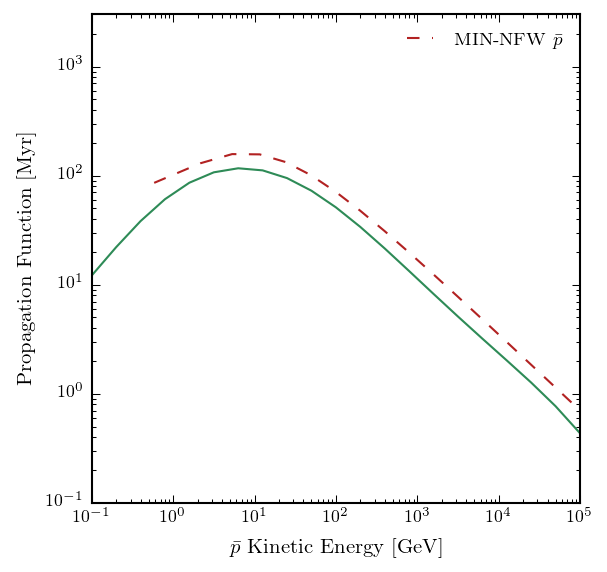

In [44]:

labels = ('MIN-NFW','MED-NFW','MAX-NFW')
linestyles = ('--','-',':')
colors = ['steelblue','steelblue','steelblue']

plt.figure(figsize=(4.2, 4.2))
# for i, prop_func in enumerate(prop_functions):
#     plt.loglog(T, prop_func, label=labels[i]+r' $\bar{p}$', ls=linestyles[i], color=colors[i])
    
    
colors = ['firebrick','firebrick','firebrick']
for i, prop_func in enumerate(prop_functions):
    
    plt.loglog(t, prop_func, label=labels[i]+r' $\bar{p}$', ls=linestyles[i], color=colors[i])
    
# Load the propagation functions from file 
with open('/data/propagation_functions/Propagation_Ann_R' + 'antiprotons' + '.dat') as f: 
    for line in f:
        if 'NFW' in line and 'MED' in line:
            a = np.array(line.split()[2:]).astype(np.float32)

# This is the propagation function defined by 1412.5696v3 eq14
prop_function = lambda T: 10**(np.sum([a[i]*np.log10(T)**i for i in range(6)],axis=0))
plt.plot(T,prop_function(T), color='seagreen')
    

plt.legend(frameon=False, )
plt.ylim(1e-1,3e3)
plt.ylabel('Propagation Function [Myr]')
plt.xlabel(r'$\bar{p}$ Kinetic Energy [GeV]')
